# UPIT 
> A fastai/PyTorch package for *U*n-*P*aired *I*mage-to-image *T*ranslation.

Code available [here](https://github.com/tmabraham/UPIT).

**UPIT** is a simple fastai/PyTorch-based package for training unpaired image-to-timage translation models, with different model implementations, training, and evaluation features.

Originally announced [in a YouTube talk](https://www.youtube.com/watch?v=gT8-wDPLOBg) on Abhishek Thakur's channel, I introduced UPIT as a simple package for using the CycleGAN model. It was built with fastai and nbdev. Please watch the video for more information about the CycleGAN model and the package. 


Since then, I have added various features (FID evaluation, Weights and Biases tracking, etc.) and new supported models (DualGAN and GANILLA). I will highlight some of these features here but see the [package documentation](https://tmabraham.github.io/UPIT/) for more information.


Here we will train a **CycleGAN** baseline.

Here's a quick summary of the CycleGAN method:
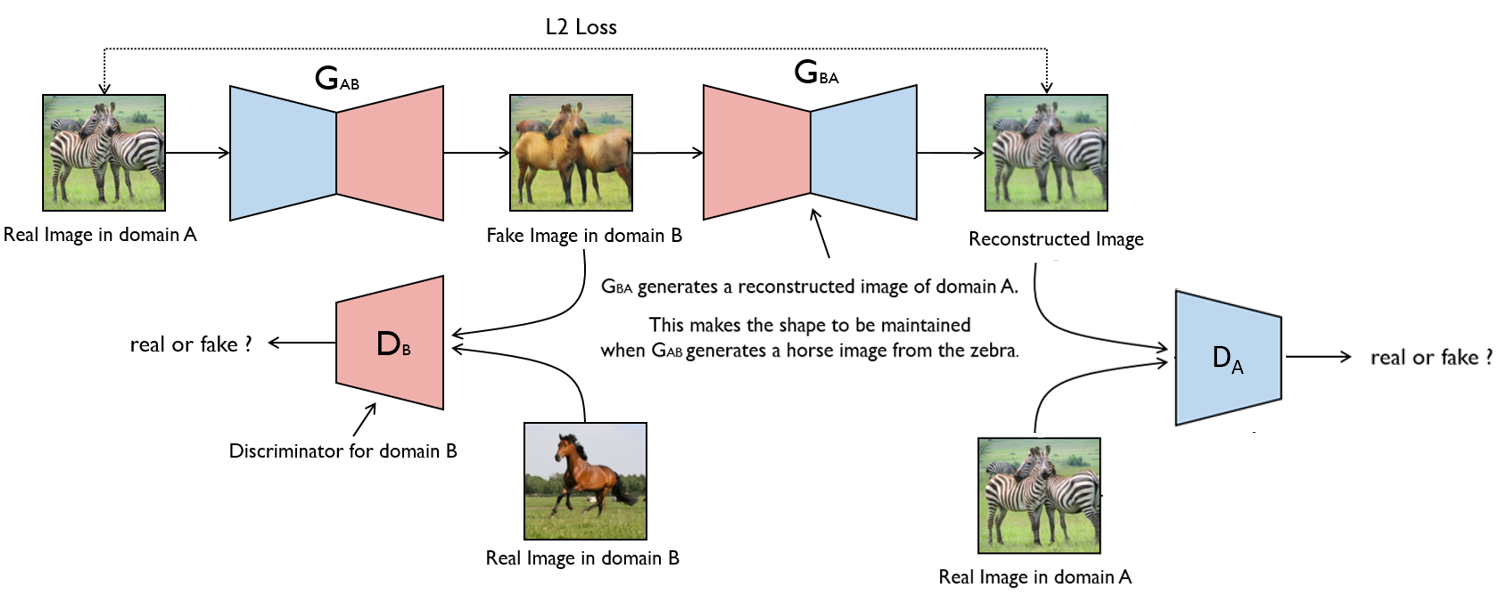

The idea is that the discriminator of domain B will provide a training signal for the generator to generate images with the style of domain B, while the cycle-consistency (reconstruction) loss will nudge the generator to maintain some aspects of the original image (like the shape and structure) in the final output image.

The generator uses the following ResNet-block-based architecture:

![generator](https://miro.medium.com/max/875/1*PVBSmRcCz9xfw-fCNi_q5g.png)

The discriminator uses a [70x70 PatchGAN](https://arxiv.org/abs/1611.07004):

![discriminator](https://miro.medium.com/max/875/1*46CddTc5JwkFW_pQb4nGZQ.png)

See my talk for more details.

Other models like DualGAN and GANILLA also function similarly, with modifications to the loss function and/or model architecture.


## Install UPIT

You can install UPIT with pip as follows:

In [ ]:
!pip install --upgrade fastai
!pip install --upgrade wandb
!pip install --upgrade torch
!pip install git+https://github.com/tmabraham/UPIT.git

UPIT is a library that is still in active development which is why we install directly from GitHub. You can also install an older version directly from PyPI
```
pip install upit
```

## Imports

UPIT has various modules:
* Data: Dataloading functionality. We support standard unpaired image-to-image translation datasets.
* Models: The different models are available under this module. Currently the CycleGAN, DualGAN, and GANILLA models are available.
* Train: The training loop functionality is available here. Most models will be fine with the CycleGAN training loop, but models that do special stuff will get a separate training loop
* Metrics: An API for common metrics used to evaluate unpaired image-to-image translation models. Currently only has support for Frechet Inception Distance, but more are coming soon.
* Inference: Inference interface for the models trained with UPIT.
* Tracking: Experiment tracking functionality goes here. Currently only Weights and Biases is supported.

Let's import them now:

In [ ]:
from upit.data.unpaired import *
from upit.models.cyclegan import *
from upit.train.cyclegan import *
from upit.inference.cyclegan import *
from upit.metrics import *
from upit.tracking.wandb import *
from fastai.vision.all import *
import wandb

## Load data

Let's define the paths for our dataset:

In [ ]:
photo2monet = Path('../input/gan-getting-started')
trainA_path = photo2monet/'photo_jpg'
trainB_path = photo2monet/'monet_jpg'
print(f"There are {len(trainA_path.ls())} photos")
print(f"There are {len(trainB_path.ls())} Monet paintings")

In the package, I provide a `get_dls` function that loads the dataset in the fastai-specific `DataLoaders` format given just the domain A and B folder paths. There is also a subset functionality (just the number of desired files are provided). See [documentation](https://tmabraham.github.io/UPIT/data.unpaired/#get_dls) for more information.

In [ ]:
dls = get_dls(trainA_path, trainB_path,load_size=256,crop_size=256)

In [ ]:
dls.show_batch()

## Model definition

I provide the `CycleGAN` class, which is just an `nn.Module` for generating converted images. See [documentation](https://tmabraham.github.io/UPIT/models.cyclegan/#Full-model) for more information. Note that the original paper uses `gen_blocks=9` but let's try a smaller model of `gen_blocks=3`.

In [ ]:
cycle_gan = CycleGAN(3,3,64,gen_blocks=3)

We need to instantiate a fastai `Learner` object used to train a model (bundles the data, model, and optimizer with callbacks, allowing for training and inference). For standard CycleGAN training, I provide the `cycle_learner` function to do this. It will add the necessary `CycleGANTrainer` callback defined in my library, allowing for the generator-discriminator training. See the [documentation](https://tmabraham.github.io/UPIT/train.cyclegan/#cycle_learner) for further details.


Note that I added the [Frechet Inception Distance](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance), a standard GAN metric (and currently the only one implemented in UPIT, but more are coming soon 😄), to allow us to better evaluate our model. It is also the metric for this competition!

I also add the Weights and Biases callback that is included in the package which allows us to better track experiments and compare results. There is a cell to load the API key (which I have stored as a secret) to W&B.

Also note the `show_img_interval` parameter. This allows us to display images from training every `show_img_interval` iterations. It does this through another special callback I have written.

In [ ]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

# I have saved my API token with "wandb_api" as Label. 
# If you use some other Label make sure to change the same below. 
wandb_api = user_secrets.get_secret("wandb_api") 

wandb.login(key=wandb_api)

In [ ]:
wandb.init()

In [ ]:
learn = cycle_learner(dls, cycle_gan,opt_func=partial(Adam,mom=0.5,sqr_mom=0.999),show_img_interval=8, 
                      cbs=[UPITWandbCallback(log_preds=True, log_model=True, log_dataset=photo2monet, folder_names=[trainA_path.name,trainB_path.name])],
                      metrics=[FrechetInceptionDistance()])

If we want, we can use the `learn.lr_find()` command to find the best learning rate. We will find it is often around 1-2e-4, which was also the recommended learning rate in the original CycleGAN paper.

In [ ]:
learn.lr_find()

The original CycleGAN paper uses a constant learning rate for half of training, and then linearly decaying to zero for the remainder of training. I added the `fit_flat_lin` method to implement this schedule. Note that the original paper runs for 200 epochs in total, but for now we run for 14 epochs.

In [ ]:
learn.fit_flat_lin(7,7,2e-4)

In [ ]:
wandb.finish()

Using some fastai functions, we can view some predictions.

In [ ]:
#cuda
b = dls.one_batch()
_,_,preds = learn.get_preds(dl=[b], with_decoded=True)

In [ ]:
dls.show_batch((b[0], b[1]), max_n=2, show=True)
plt.suptitle('Input')
dls.show_batch((preds[1],preds[0]), max_n=2, show=True)
plt.suptitle('Predictions')

Finally, I provide `get_preds_cyclegan` to generate predictions from images in `testA_path` and save to `pred_path`. See [documentation](https://tmabraham.github.io/UPIT/inference.cyclegan/#get_preds_cyclegan).

In [ ]:
testA_path = '../input/gan-getting-started/photo_jpg/'
pred_path = '../images/'

In [ ]:
get_preds_cyclegan(learn,testA_path,pred_path,suffix='jpg')

Thankfully, all that's needed for submission is a zipped folder of those predicted images:

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

## Conclusion:

To summarize, my package makes CycleGAN training and inference easy and effortless. It simply takes effectively five lines of code:
```
dls = get_dls(trainA_path, trainB_path)
cycle_gan = CycleGAN(3,3,64,gen_blocks=3)
learn = cycle_learner(dls, cycle_gan,opt_func=partial(Adam,mom=0.5,sqr_mom=0.999),show_img_interval=8)
learn.fit_flat_lin(7,7,2e-4)
get_preds_cyclegan(learn, testA_path, preds_path)
```

Please upvote this kernel if you found this helpful! Additionally, please check out my [talk](https://www.youtube.com/watch?v=gT8-wDPLOBg) for more information! 

You can also try using DualGAN and GANILLA models. I plan to implement other unpaired image-to-image translation models in this public library. I am currently planning to add:
- CUT
- U-GAT-IT
- UNIT

**Comment below** if you have suggestions for other **unpaired image-to-image translation** models to add.

Additionally, I plan to add easier methods for viewing results (including during training) and better support for using custom models. **Let me know if you have any suggested features!**

## Acknowledgements

Thank you to Andrew Shaw for his help porting over the fastai v1 code. Thank you to the fast.ai team for providing the original fastai v1 version of the CycleGAN.

Diagrams were taken (w/ or w/o modification) from [here](https://github.com/yunjey/mnist-svhn-transfer) and [here](https://towardsdatascience.com/cyclegan-learning-to-translate-images-without-paired-training-data-5b4e93862c8d).